Model se nalazi na uređaju: cuda


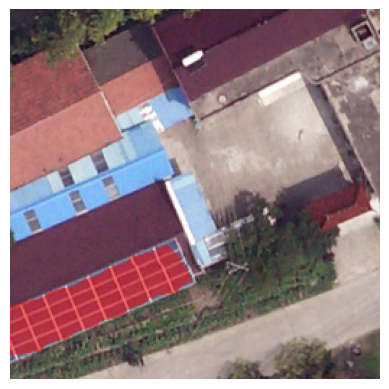

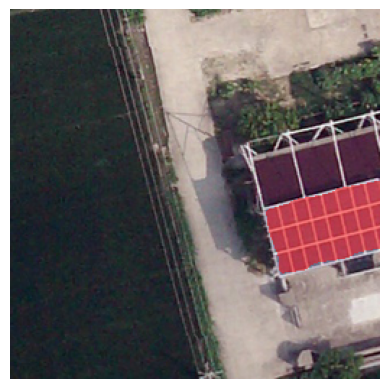

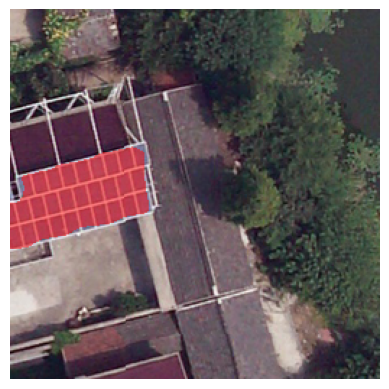

In [6]:
from src.utils.data_preparation import process_images
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from src.utils.models import load_model_state
import torch
import os
from torchvision.transforms import transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

source_dir = 'images'
target_dir = 'processed_images'

# Obrada svih slika
process_images(source_dir, target_dir)

image_files = [os.path.join(target_dir, f) for f in os.listdir(target_dir)]

# Load the model
model = load_model_state(
    model_name='deeplabv3_resnet50', 
    path='../models/best/deeplabv3_resnet50_BCEWithLogitsLoss_e20_bs2_lr0.001.pth'
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Model se nalazi na uređaju:", device)
model.to(device)

with torch.no_grad():
    model.eval()  # Postavljanje modela u evaluacijski način rada
    for img_path in image_files:
        orginal_img = Image.open(img_path).convert("RGB")
        img = transform(orginal_img).unsqueeze(0).to(device)  # Dodavanje dodatne dimenzije i premještanje na uređaj
        output = model(img)['out']
        predicted_mask = torch.sigmoid(output).cpu().detach().squeeze(0).squeeze(0)  # Uklanjanje dodatnih dimenzija

        # Pretvaranje PyTorch tenzora maske u PIL sliku
        mask = (predicted_mask.numpy() * 255).astype(np.uint8)  # Skaliranje na 0-255
        mask_image = Image.fromarray(mask)  # Nema potrebe za squeeze jer smo to već učinili
        
        
        # Pretvorit sivu sliku maske u RGBA da bismo dodali prozirnost
        mask_rgba = mask_image.convert("RGBA")
        datas = mask_rgba.getdata()
        # Postavit prozirnost maske
        new_data = []
        cutoff = 128  # Prag za binarizaciju
        for item in datas:
            # Ako je maska iznad praga, nanesi crvenu boju s prozirnošću 128
            if item[0] > cutoff:
                new_data.append((255, 0, 0, 128))  # Crvena boja s polovičnom prozirnošću
            else:
                new_data.append((255, 255, 255, 0))  # Potpuno prozirno
        mask_rgba.putdata(new_data)
        
        # Spoji originalnu sliku i masku
        combined = Image.alpha_composite(orginal_img.convert("RGBA"), mask_rgba)
        
        # Prikaz kombinirane slike
        plt.imshow(combined)
        plt.axis('off')  # Isključivanje osi
        plt.show()


In [1]:
import torch
if torch.cuda.is_available():
    print("CUDA je dostupna. Broj dostupnih CUDA uređaja:", torch.cuda.device_count())
    print("Naziv CUDA uređaja:", torch.cuda.get_device_name(0))
else:
    print("CUDA nije dostupna.")


CUDA je dostupna. Broj dostupnih CUDA uređaja: 1
Naziv CUDA uređaja: Quadro P520
